<a href="https://colab.research.google.com/github/Renator12/DATA-SCIENCE-PROJECTS-TMU/blob/main/multvariate_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost

In [ ]:
!pip install lightgbm

In [ ]:
!pip install statsmodels


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving park_visitation.csv to park_visitation (1).csv
Saving weather_data.csv to weather_data (1).csv


In [ ]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [ ]:
import sklearn
import lightgbm as lgb
import pandas as pd
from pylab import rcParams
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
rcParams['figure.figsize']=12,5

# Goal:Analyze the weather data and find insights that could help predict visitation patterns at a park.


### We are tackling a multivariate time series forecasting problem. Our approach will concentrate on feature engineering with weather data to identify seasonal patterns and incorporate features based on it (e.g., a seasonal feature). Additionally, we will include lag values since today's number of visitors is likely dependent on yesterday's count (not independent). We will also address null values and manage the large number of features by removing them accordingly.

##### FORECASTING MODELS WILL FOCUS ON USING TREE BASED REGRESSION WITH BOOSTING AND ENSEMBLES AND A METRIC OF Mean absolute error for performance.
MAE is better suited for forecasting evaluations when robustness to outliers is paramount, as it treats all errors equally without squaring them. Its simplicity and interpretability make it a preferred choice when communicating forecasting performance, especially in scenarios where outliers can heavily skew results or when equal weighting of errors is desired.

In [ ]:
park_visits=pd.read_csv('park_visitation.csv') #read csv's
weather_data=pd.read_csv('weather_data.csv')

# DATASET STRUCTURE ANALYSIS

In [ ]:
weather_data_cols=set(weather_data.columns) #exploring weather_data columns
len(weather_data)

1096

In [ ]:
weather_data['TEMPERATURE_HEAT_INDEX_24HR_DEP'] #lot of empty nulls in this feature.lets explore this null issue more

,TEMPERATURE_HEAT_INDEX_24HR_DEP
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
1091,NaN
1092,NaN
1093,NaN
1094,NaN


In [ ]:
#rename weather data date column from DATE_CALENDAR TO DATE
weather_data.rename(columns={'DATE_CALENDAR': 'DATE'}, inplace=True)
weather_data.head()

,DATE,CLOUD_BASE_HEIGHT_24HR_DEP,CLOUD_BASE_HEIGHT_AVG,CLOUD_BASE_HEIGHT_MAX,CLOUD_BASE_HEIGHT_MIN,CLOUD_COVER_24HR_DEP,CLOUD_COVER_AVG,CLOUD_COVER_MAX,CLOUD_COVER_MIN,CLOUD_COVER_PERC_24HR_DEP,...,WIND_GUST_MAX,WIND_GUST_MIN,WIND_GUST_INSTANTANEOUS_24HR_DEP,WIND_GUST_INSTANTANEOUS_AVG,WIND_GUST_INSTANTANEOUS_MAX,WIND_GUST_INSTANTANEOUS_MIN,WIND_SPEED_24HR_DEP,WIND_SPEED_AVG,WIND_SPEED_MAX,WIND_SPEED_MIN
0,2021-03-13,-1376,1063.0,1063.0,1063.0,-0.01,0.18,0.74,0.00,-1,...,11.63,4.30,-2.40,8.19,10.84,3.73,-1.51,5.11,7.44,2.27
1,2021-03-14,255,1318.0,2482.0,586.0,-0.03,0.15,0.85,0.00,-2,...,15.89,5.55,3.20,11.39,15.75,5.44,1.90,7.00,9.30,3.81
2,2021-03-15,7448,8767.0,11406.0,6184.0,0.18,0.33,1.00,0.00,18,...,10.45,5.42,-3.89,7.50,10.47,5.12,-2.68,4.32,6.52,2.04
3,2021-03-16,-6705,2061.0,5232.0,424.0,0.55,0.88,1.00,0.45,55,...,11.48,3.11,0.81,8.30,11.20,2.88,1.16,5.48,7.33,2.03
4,2021-03-17,639,2700.0,7604.0,680.0,-0.07,0.81,1.00,0.47,-7,...,6.18,2.49,-4.54,3.76,6.07,2.06,-3.43,2.05,3.03,1.30


In [ ]:
list(weather_data.columns) #LOTS OF FEATURES !!

['DATE',
 'CLOUD_BASE_HEIGHT_24HR_DEP',
 'CLOUD_BASE_HEIGHT_AVG',
 'CLOUD_BASE_HEIGHT_MAX',
 'CLOUD_BASE_HEIGHT_MIN',
 'CLOUD_COVER_24HR_DEP',
 'CLOUD_COVER_AVG',
 'CLOUD_COVER_MAX',
 'CLOUD_COVER_MIN',
 'CLOUD_COVER_PERC_24HR_DEP',
 'CLOUD_COVER_PERC_AVG',
 'CLOUD_COVER_PERC_MAX',
 'CLOUD_COVER_PERC_MIN',
 'DEGREE_DAYS_COOLING',
 'DEGREE_DAYS_EFFECTIVE',
 'DEGREE_DAYS_FREEZING',
 'DEGREE_DAYS_GROWING',
 'DEGREE_DAYS_HEATING',
 'EVAPOTRANSPIRATION_LWE_TOTAL',
 'HAS_FREEZING_RAIN',
 'FREEZING_RAIN_LWE_TOTAL',
 'FREEZING_RAIN_LWE_RATE_AVG',
 'FREEZING_RAIN_LWE_RATE_MAX',
 'FREEZING_RAIN_LWE_RATE_MIN',
 'HUMIDITY_RELATIVE_24HR_DEP',
 'HUMIDITY_RELATIVE_AVG',
 'HUMIDITY_RELATIVE_MAX',
 'HUMIDITY_RELATIVE_MIN',
 'HAS_ICE',
 'ICE_LWE_TOTAL',
 'ICE_LWE_RATE_AVG',
 'ICE_LWE_RATE_MAX',
 'ICE_LWE_RATE_MIN',
 'INDEX_UV_24HR_DEP',
 'INDEX_UV_AVG',
 'INDEX_UV_MAX',
 'INDEX_UV_MIN',
 'MINUTES_OF_FREEZING_RAIN_TOTAL',
 'MINUTES_OF_ICE_TOTAL',
 'MINUTES_OF_PRECIPITATION_TOTAL',
 'MINUTES_OF_RAIN_TOTAL

In [ ]:
object_columns=weather_data[list(weather_data.select_dtypes(include=['object']).columns)] #all columns of type object
len(object_columns)

1096

In [ ]:
object_columns.isna().sum() #checking NULLS IN OBJECT COLUMNS

,0
DATE,0
HAS_FREEZING_RAIN,164
HAS_ICE,164
PRECIPITATION_INTENSITY_MAX,727
PRECIPITATION_TYPE_DESC_PREDOMINANT,0
HAS_RAIN,164
HAS_SLEET,164
SNOW_DRIFTING_INTENSITY_MAX,1087


# DEALING WITH NAN  VALUES

##### THE DIAGRAM BELOW SHOWS ALL THE FEATURES WITH COLUMNS HAVING MORE THAN 30% NULL VALUES.WE USE A NULL THRESHOLD TO ERADICATE THESE COLUMNS.OUR NULL THRESHOLD IS SET AT 30%

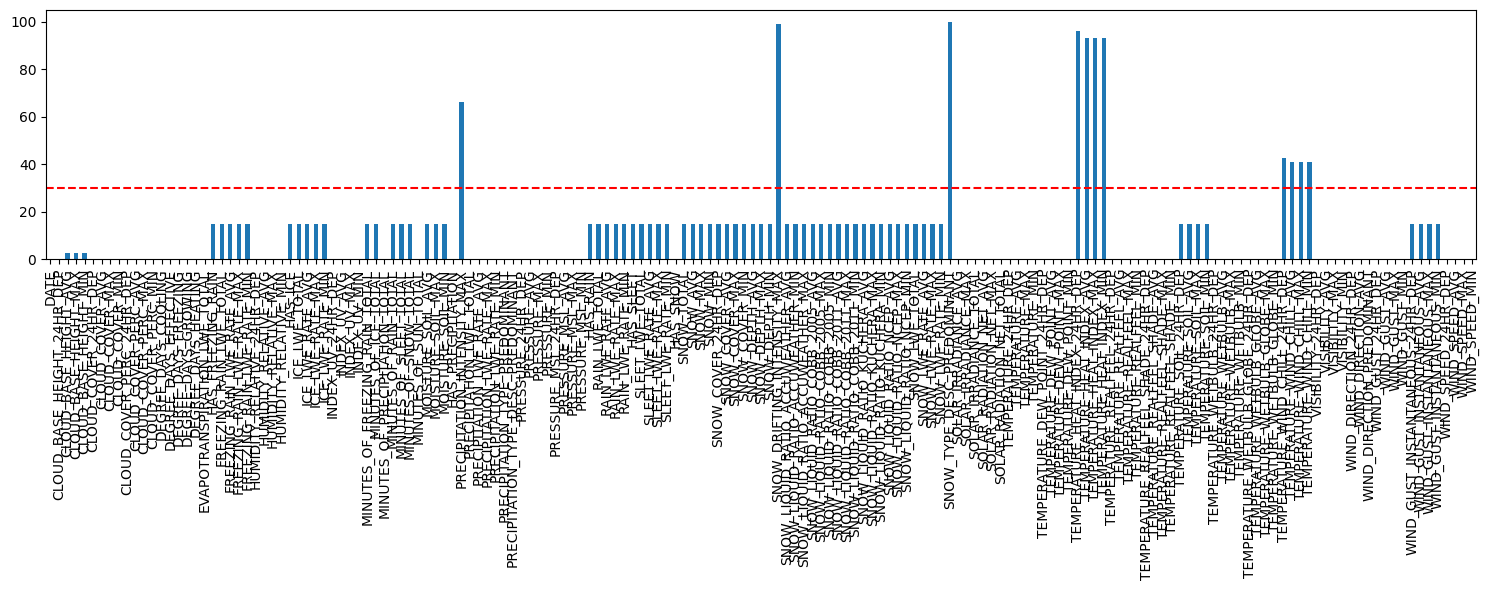

In [ ]:
empty_values_per_column=(weather_data.isna().sum()/len(weather_data))*100 #eradicate columns with empty cells more than 30%
plt.figure(figsize=(15,6))  # Adjust figsize as needed
empty_values_per_column.plot(kind='bar')
plt.axhline(y=30, color='r', linestyle='--') #30% threshold
plt.tight_layout()

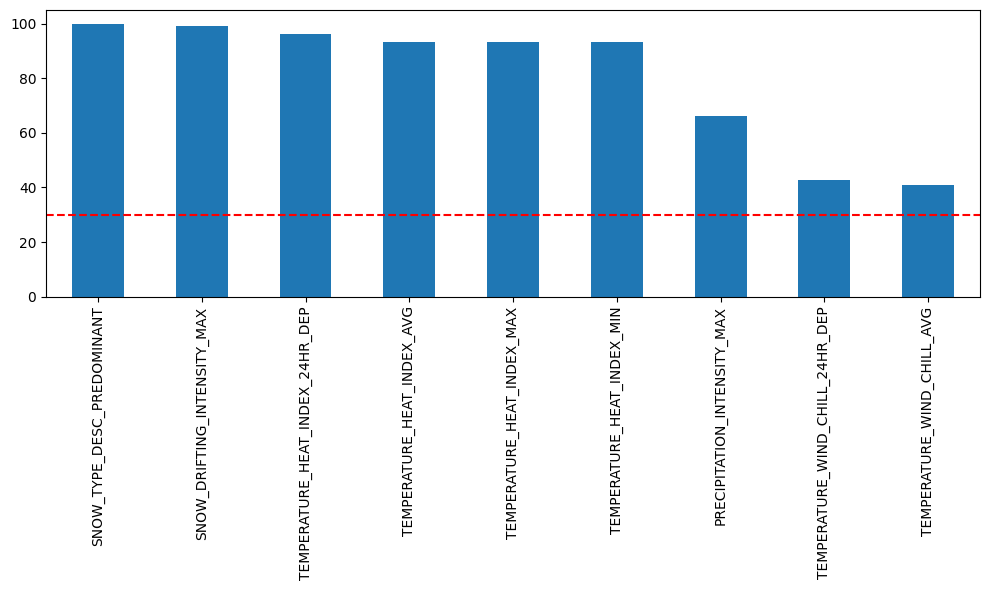

In [ ]:
#plotting the columns with empty values over 30% .
empty_vals_top_9=empty_values_per_column.nlargest(9) #see that the temperature _heat _index and wind_chills are missing.might be defective sensors
plt.figure(figsize=(10,6))  # Adjust figsize as needed
empty_vals_top_9.plot(kind='bar',)
plt.axhline(y=30, color='r', linestyle='--') #30% threshold
plt.tight_layout()

In [ ]:
#dropping these columns
weather_data.drop(columns=list(empty_vals_top_9.index), inplace=True)


In [ ]:
num_columns=weather_data[list(weather_data.select_dtypes(include=['number']).columns)] #exploring number columns
num_columns

,CLOUD_BASE_HEIGHT_24HR_DEP,CLOUD_BASE_HEIGHT_AVG,CLOUD_BASE_HEIGHT_MAX,CLOUD_BASE_HEIGHT_MIN,CLOUD_COVER_24HR_DEP,CLOUD_COVER_AVG,CLOUD_COVER_MAX,CLOUD_COVER_MIN,CLOUD_COVER_PERC_24HR_DEP,CLOUD_COVER_PERC_AVG,...,WIND_GUST_MAX,WIND_GUST_MIN,WIND_GUST_INSTANTANEOUS_24HR_DEP,WIND_GUST_INSTANTANEOUS_AVG,WIND_GUST_INSTANTANEOUS_MAX,WIND_GUST_INSTANTANEOUS_MIN,WIND_SPEED_24HR_DEP,WIND_SPEED_AVG,WIND_SPEED_MAX,WIND_SPEED_MIN
0,-1376,1063.0,1063.0,1063.0,-0.01,0.18,0.74,0.00,-1,17,...,11.63,4.30,-2.40,8.19,10.84,3.73,-1.51,5.11,7.44,2.27
1,255,1318.0,2482.0,586.0,-0.03,0.15,0.85,0.00,-2,15,...,15.89,5.55,3.20,11.39,15.75,5.44,1.90,7.00,9.30,3.81
2,7448,8767.0,11406.0,6184.0,0.18,0.33,1.00,0.00,18,33,...,10.45,5.42,-3.89,7.50,10.47,5.12,-2.68,4.32,6.52,2.04
3,-6705,2061.0,5232.0,424.0,0.55,0.88,1.00,0.45,55,88,...,11.48,3.11,0.81,8.30,11.20,2.88,1.16,5.48,7.33,2.03
4,639,2700.0,7604.0,680.0,-0.07,0.81,1.00,0.47,-7,81,...,6.18,2.49,-4.54,3.76,6.07,2.06,-3.43,2.05,3.03,1.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,-499,3288.0,6096.0,1067.0,0.24,0.50,1.00,0.00,23,50,...,16.46,6.03,NaN,NaN,NaN,NaN,4.42,8.52,12.35,2.78
1092,-2364,924.0,7162.0,396.0,0.47,0.98,1.00,0.76,47,97,...,10.81,2.94,NaN,NaN,NaN,NaN,-4.18,4.34,7.72,0.77
1093,951,1875.0,9448.0,61.0,-0.02,0.96,1.00,0.82,-1,95,...,17.49,2.70,NaN,NaN,NaN,NaN,2.73,7.07,11.32,0.80
1094,5515,7391.0,8686.0,6096.0,-0.77,0.19,0.76,0.00,-77,18,...,16.46,2.06,NaN,NaN,NaN,NaN,0.22,7.29,10.81,2.06


In [ ]:
weather_data.head(10) #exploring weather_data

,DATE,CLOUD_BASE_HEIGHT_24HR_DEP,CLOUD_BASE_HEIGHT_AVG,CLOUD_BASE_HEIGHT_MAX,CLOUD_BASE_HEIGHT_MIN,CLOUD_COVER_24HR_DEP,CLOUD_COVER_AVG,CLOUD_COVER_MAX,CLOUD_COVER_MIN,CLOUD_COVER_PERC_24HR_DEP,...,WIND_GUST_MAX,WIND_GUST_MIN,WIND_GUST_INSTANTANEOUS_24HR_DEP,WIND_GUST_INSTANTANEOUS_AVG,WIND_GUST_INSTANTANEOUS_MAX,WIND_GUST_INSTANTANEOUS_MIN,WIND_SPEED_24HR_DEP,WIND_SPEED_AVG,WIND_SPEED_MAX,WIND_SPEED_MIN
0,2021-03-13,-1376,1063.0,1063.0,1063.0,-0.01,0.18,0.74,0.00,-1,...,11.63,4.30,-2.40,8.19,10.84,3.73,-1.51,5.11,7.44,2.27
1,2021-03-14,255,1318.0,2482.0,586.0,-0.03,0.15,0.85,0.00,-2,...,15.89,5.55,3.20,11.39,15.75,5.44,1.90,7.00,9.30,3.81
2,2021-03-15,7448,8767.0,11406.0,6184.0,0.18,0.33,1.00,0.00,18,...,10.45,5.42,-3.89,7.50,10.47,5.12,-2.68,4.32,6.52,2.04
3,2021-03-16,-6705,2061.0,5232.0,424.0,0.55,0.88,1.00,0.45,55,...,11.48,3.11,0.81,8.30,11.20,2.88,1.16,5.48,7.33,2.03
4,2021-03-17,639,2700.0,7604.0,680.0,-0.07,0.81,1.00,0.47,-7,...,6.18,2.49,-4.54,3.76,6.07,2.06,-3.43,2.05,3.03,1.30
5,2021-03-18,774,3475.0,7198.0,879.0,0.17,0.98,1.00,0.53,16,...,14.22,3.58,6.52,10.28,14.15,4.05,4.47,6.51,9.42,2.18
6,2021-03-19,3927,7402.0,7402.0,7402.0,-0.98,0.00,0.00,0.00,-97,...,14.18,4.23,-2.40,7.88,13.94,4.09,-1.56,4.96,9.19,1.67
7,2021-03-20,4789,NaN,NaN,NaN,0.01,0.01,0.09,0.00,0,...,6.25,4.11,-2.77,5.11,6.10,3.94,-1.40,3.56,4.76,2.83
8,2021-03-21,0,NaN,NaN,NaN,-0.01,0.00,0.00,0.00,0,...,6.74,2.46,-1.13,3.98,6.70,2.21,-1.28,2.29,3.64,1.08
9,2021-03-22,-4037,8154.0,9551.0,7320.0,0.36,0.36,0.99,0.00,35,...,7.04,2.11,0.60,4.57,6.96,2.13,0.46,2.75,3.78,0.77


In [ ]:
weather_data.isna().sum().nlargest(35)    #lots of null values in these columns

,0
TEMPERATURE_WIND_CHILL_MAX,450
TEMPERATURE_WIND_CHILL_MIN,450
HAS_FREEZING_RAIN,164
FREEZING_RAIN_LWE_TOTAL,164
FREEZING_RAIN_LWE_RATE_AVG,164
FREEZING_RAIN_LWE_RATE_MAX,164
FREEZING_RAIN_LWE_RATE_MIN,164
HAS_ICE,164
ICE_LWE_TOTAL,164
ICE_LWE_RATE_AVG,164


In [ ]:
weather_data['HAS_FREEZING_RAIN'].value_counts() #freezing rain data very skewed.this is the case for several features

,count
HAS_FREEZING_RAIN,
False,878
True,54


<Axes: xlabel='HAS_FREEZING_RAIN', ylabel='count'>

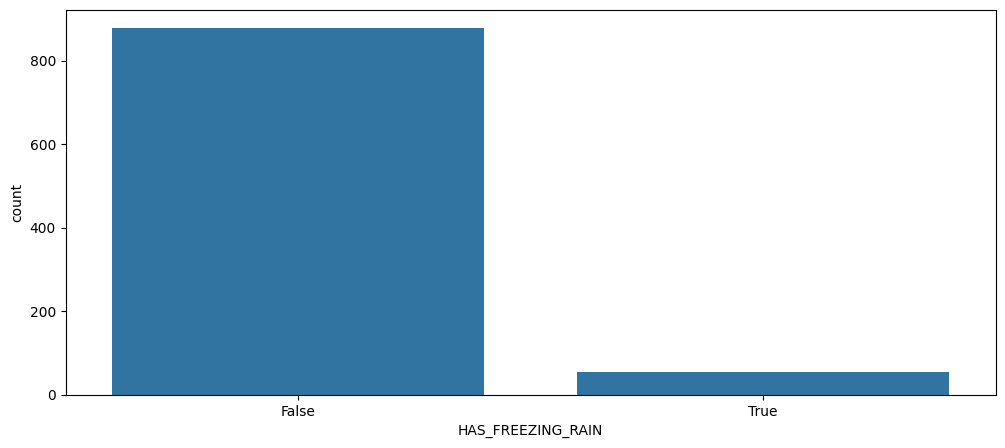

In [ ]:
sns.countplot(x='HAS_FREEZING_RAIN', data=weather_data) #this represents real life conditions since it doesnt have freezing rain so often


In [ ]:
corr_matrix =weather_data.corr().abs() #exploring correlations .too many features for heatmaps just yet
corr_matrix['CLOUD_BASE_HEIGHT_AVG']

ValueError: could not convert string to float: '2021-03-13'

# DEALING WITH MULTICOLLINEARITY


#### Multicollinearity occurs when independent variables in a regression model are highly correlated with each other. This can lead to issues in the interpretation of coefficients and can inflate the standard errors of the coefficients, making them unreliable. To address multicollinearity, create a correlation map between features to identify highly correlated columns, then remove one of each correlated pair. This helps reduce redundancy and ensures the robustness of the regression model, preserving the independence of predictors while maintaining model interpretability and performance.

In [ ]:
threshold = 0.75  #set multicollinearity threshold to 75%
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
weather_data_filtered=weather_data.drop(to_drop, axis=1)

In [ ]:
list(weather_data.columns) #CURRENT WEATHER COLUMNS

In [ ]:
weather_data_filtered.head(10) #current dataframe

In [ ]:
# another feature engineering CLOUD_BASE.We see that cloud_base_height_avg is the just the average of cloud_bases
#so we can drop theother cloud_base features and focus on one.There are similar other features I show below
def plot_min_max_avg(df,min_name,avg_name,max_name):

    plt.plot(df[min_name], label=min_name)
    plt.plot(weather_data_filtered[avg_name], label=avg_name)
    plt.plot(weather_data_filtered[max_name], label=max_name)
    plt.legend()



In [ ]:
plot_min_max_avg(weather_data_filtered,'CLOUD_BASE_HEIGHT_24HR_DEP','CLOUD_BASE_HEIGHT_AVG','CLOUD_BASE_HEIGHT_MAX')

In [ ]:
weather_data_filtered.drop(columns=['CLOUD_BASE_HEIGHT_24HR_DEP','CLOUD_BASE_HEIGHT_MAX'],inplace=True) #dropping similar features

In [ ]:
plot_min_max_avg(weather_data_filtered,'CLOUD_COVER_24HR_DEP','CLOUD_COVER_AVG','CLOUD_COVER_MAX')#dropping more similar features

In [ ]:
weather_data_filtered.drop(columns=['CLOUD_COVER_24HR_DEP','CLOUD_COVER_MAX','CLOUD_COVER_MIN'],inplace=True)#dropping similar columns

In [ ]:
weather_data_filtered['DEGREE_DAYS_COOLING'].plot()#we see a seasonal trend in some of the features

In [ ]:
weather_data_filtered['DEGREE_DAYS_EFFECTIVE'].plot()#seasonal trend

# CATEGORICAL COUNTPLOTS VISUALIZATION

###### WE SEE THE SKEWNESS FOR A LOT OF OUR FEATURES.THIS IS A REPRESENTATIVE OF THE REAL WEATHER NOT UNDERSAMPLING SINCE MOST PLACES DONOT HAVE FREEZING RAINS AND ICE FOR MOST OF THE YEAR AND HENCE NOT AN ISSUE.HOWEVER, THERE ARE MULTIPLE FEATURES REPRESENTING SIMILAR THINGS. FREEZING RAIN AND HAS_ICE HAVE SIMILAR VALUES BECAUSE THEY MOSTLY OCCUR DURING THE SAME TIME AND ARE VERY CORRELATED.WE REMOVE SOME OF THEM.HAS_SLEET HAS ONLY ONE VALUE AND HENCE COMPLETELY USELESS FOR OUR ANALYSIS

In [ ]:
#PLOTTING CATEGORICAL VARIABLES COUNT PLOTS
object_columns=weather_data_filtered[list(weather_data.select_dtypes(include=['object']).columns)]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))

# Loop through each column and create count plot
for i, column in enumerate(object_columns.columns[1:-1]):
    sns.countplot(data=object_columns, x=column, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Count Plot for {column}')

plt.tight_layout()
plt.show()

In [ ]:
object_columns.columns[1:] #ALL THE CATEGORICAL COLUMNS

In [ ]:
#VISUALIZING SOME OF THESE VARIABLES WITH THE MONTH.CREATE THE MONTH FEATURE MANUALLY
weather_data_filtered['month']=pd.DatetimeIndex(weather_data_filtered['DATE']).month
month_mapping = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
weather_data_filtered['month'] = weather_data_filtered['month'].apply(lambda x: month_mapping.get(x, x))


In [ ]:
#Shows the occurence of freezing rain during the year

sns.countplot(data=weather_data_filtered, x='month', hue='HAS_FREEZING_RAIN')

In [ ]:
#Shows the occurence of has ice during the year.EXACTLY THE SAME AS FREEZING RAIN.remove one of them!

sns.countplot(data=weather_data_filtered, x='month', hue='HAS_ICE')


In [ ]:
#Data shows that the place gets a lot of rain during the year.This can be important for mapping the environmental factors
sns.countplot(data=weather_data_filtered, x='month', hue='HAS_RAIN')


# We see that the plots for freezing rain and ice are pretty much the same!

In [ ]:
sns.countplot(data=weather_data_filtered, x='month', hue='HAS_ICE')


In [ ]:
sns.countplot(data=weather_data_filtered, x='month', hue='HAS_RAIN')


In [ ]:
#dropping all the correlated columns or columns with no information gain.
weather_data_filtered.drop(columns=['HAS_SLEET','PRECIPITATION_TYPE_DESC_PREDOMINANT','HAS_FREEZING_RAIN','SNOW_DRIFTING_INTENSITY_MAX'],inplace=True)

In [ ]:
#perfect example of one column with no information gain since its only 0'S.
weather_data_filtered['FREEZING_RAIN_LWE_RATE_MIN'].value_counts()

# ONE HOT ENCODING CATEGORICAL VARIABLES

In [ ]:
#converting categorical variables into one hot encoded forms
object_columns = weather_data_filtered.select_dtypes(include=['object']).drop(columns=['month','DATE'])

weather_data_encoded = pd.get_dummies(weather_data_filtered, columns=object_columns.columns)


In [ ]:
weather_data_encoded.head(10)

In [ ]:
weather_data_cols-set(weather_data.columns) #the current colu

In [ ]:
weather_data.corr()

In [ ]:
weather_data_encoded.isna().sum().nlargest(30)

In [ ]:
weather_data['HAS_SLEET'].value_counts() #useless hence remove all sleets.gives away area does not have sleet usually


In [ ]:
#exploring some of the nan values in these columns.shows percent empty in columns.
empty_values_per_column[(empty_values_per_column<20)&(empty_values_per_column>5)]

## EXPLORING PARK VISITOR TIME SERIES DATA

In [ ]:
#using park_visits data
park_visits.head()

In [ ]:
park_visits['DATE'] = pd.to_datetime(park_visits['DATE']) #converting dates
park_2 = park_visits.set_index('DATE').asfreq('D')


In [ ]:
park_2['ESTIMATED_VISITS'].fillna(park_2['ESTIMATED_VISITS'].mean(),inplace=True) #imputing with mean

In [ ]:
plt.plot(park_visits['ESTIMATED_VISITS']) #plotting the estimated visits.We see some seasonality in this plot.

In [ ]:
# This function is used to visualize the autocorrelation of a time series, which represents the correlation
# between a series and a lagged version of itself at different time lags.
#The plot helps in understanding the presence of patterns or dependencies within the time series data.
fig = plot_acf(park_visits['ESTIMATED_VISITS'], lags=24)
plt.xlabel('LAG')
plt.ylabel('ACF')
plt.show()

In [ ]:
#USING ETS TO DECOMPOSE OUR TIME SERIES INTO TREND ,SEASONAL AND RESIDUAL PORTIONS.SHOWS CLEAR PRESENCE OF SEASONS.
ets = seasonal_decompose(park_2, model='multiplicative')
ets.plot();


In [ ]:
#The code conducts an Augmented Dickey-Fuller test on the 'ESTIMATED_VISITS' time series data to assess its stationarity.
#It prints the p-value associated with the test, indicating the likelihood of the data being non-stationary; if the p-value is below a significance level (e.g., 0.05), it suggests rejecting the null hypothesis of stationarity, indicating non-stationarity in the time series.
result = adfuller(park_visits['ESTIMATED_VISITS'])
print('p-value: %f' % result[1])


In [ ]:
#ADDING A SEASON FEATURE TO OUR DATASET SINCE IT SHOWS STRONG SEASONALITY
park_visits['month'] = park_visits['DATE'].dt.month


In [ ]:
def find_season(val): #finds the season based on month number
    if val in [1, 2, 12]:
        return 4 #winter
    elif val in [3, 4, 5]:
        return 2 #spring
    elif val in [6, 7, 8]:
        return 1 #summer
    elif val in [9, 10, 11]:
        return 3 #fall

In [ ]:
#Added a season feature
park_visits['month_val']=park_visits['month'].apply(find_season)
park_visits.head()

In [ ]:
#we see that the highest number of visitors are during the summer and spring months

sns.barplot(data=park_visits,x='month_val',y='ESTIMATED_VISITS')
plt.xlabel('Month')
plt.title('Estimated Visits to the Park by Month. 1 is summer ,2 is spring , 3 is fall , 4 is winter')


In [ ]:
len(park_visits)

In [ ]:
#dropping the column.not needed now
park_visits['DATE'].max()
park_visits.drop('month', axis=1, inplace=True)


In [ ]:
#converting date
weather_data_encoded['DATE']=pd.to_datetime(weather_data['DATE'])

In [ ]:
#merging the 2 dataframes together .left join on park_visits
merged_df = pd.merge(park_visits, weather_data_encoded, on='DATE', how='left')
merged_df.head()

In [ ]:
merged_df['month_val'].value_counts()

# USING DECISION TREE FOR FEATURE ENGINEERING TO CALCULATE FEATURE IMPORTANCES

#### In regression, decision trees provide information on feature importance by assessing how much each feature reduces the variance of the target variable across the splits. Features that result in larger reductions in variance are considered more important, as they contribute more to explaining the variance in the target variable.

In [ ]:
clf = DecisionTreeClassifier()
merged_df=merged_df.dropna()
X=merged_df.drop(['ESTIMATED_VISITS','DATE',],axis=1)
Y=merged_df['ESTIMATED_VISITS']


In [ ]:
X.head()

In [ ]:
#Tree-based models such as Decision Trees, Random Forests, and Gradient Boosted Trees can be robust against outliers to some extent
sns.boxplot(X['CLOUD_BASE_HEIGHT_AVG']) #SEE THE PRESENCE OUTLIERS.

In [ ]:
#creating a lag variable since we saw that there is some autocorrelation in our time series
merged_df['lagged_estimated_visits']=merged_df['ESTIMATED_VISITS'].shift(1)

In [ ]:
merged_df.head()

In [ ]:
#fill empty rows with means.We cannot leave time series values empty or we will need to resample.
merged_df['lagged_estimated_visits'].fillna(merged_df['lagged_estimated_visits'].mean(), inplace=True)


In [ ]:
X.drop(['month'],axis=1,inplace=True)

In [ ]:
#using decision tree for feature importances
clf = DecisionTreeClassifier()
merged_df=merged_df.dropna()

clf.fit(X, Y)


In [ ]:
#getting the top features based on importances
feature_importances = clf.feature_importances_
top_indices = np.argsort(feature_importances)[::-1][feature_importances > 0.02]

top_indices

In [ ]:
#all important columns.choosing just 12 of the features
important_cols=list(X.columns[top_indices])[:12]

In [ ]:
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

In [ ]:
#WE SEE THAT MONTH VAL WHICH SHOWS THE SEASON HAS A BIG CORRELATION WITH ESTIMATED VISITS
important_cols.append('month_val')
important_cols.append('ESTIMATED_VISITS')
sns.heatmap(merged_df[important_cols].corr().abs(),annot=True)

In [ ]:
removal=important_cols.pop()
removal

In [ ]:
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

# MODELS USED BELOW ->DECISION TREE ,RANDOM FORESTS,XGBOOST,LGBM,XGBOOST WITH GRDISEARCHCV


#### Tree-based models, such as Random Forests and Gradient Boosting Machines (including XGBoost, LightGBM, and CatBoost), are advantageous for time series forecasting due to their ability to capture non-linear relationships, handle multicollinearity, provide feature importance, robustness to outliers and missing data, scalability, and interpretability. These models excel in capturing complex patterns inherent in time series data while remaining interpretable

In [ ]:
X_a=merged_df[important_cols] #popping to remove estimated visits
Y_a=merged_df['ESTIMATED_VISITS']

len(Y_a)

In [ ]:
X.head(10)

In [ ]:
#creating a 80-20 split.Since this is a time series,we cannot have a random split but have a time frame instead.
half_80=int(len(X_a)*(0.8))
test_size=len(X_a)-(half_80)
X_train=X_a.iloc[:half_80]
X_test=X_a.iloc[half_80:]
Y_test=Y_a[X_test.index]
Y_train=Y_a[X_train.index]
X_test

In [ ]:
#DECISION TREE CLASSIFIER.OUR BASELINE ESTIMATOR
clf2 = DecisionTreeClassifier()
clf2.fit(X_train, Y_train)
y_pred_clf = clf2.predict(X_test)
plt.plot(y_pred_clf,label='DT REGRESSOR',color='blue')
plt.plot(Y_test.values,label='REAL DATA',color='red')
plt.legend()

In [ ]:
mae_ = mae(Y_test, y_pred_clf) #BASELINE MEAN AVERAGE ERROR OF 2455.04
mae_

In [ ]:
clf_rf = RandomForestClassifier() #RANDOM FOREST CLASSIFIER
clf_rf.fit(X_train, Y_train)
y_pred_rf = clf_rf.predict(X_test)
plt.plot(y_pred_rf,label='RANDOM FOREST REGRESSOR',color='blue')
plt.plot(Y_test.values,label='REAL DATA',color='red')
plt.legend()

In [ ]:
mae_4 = mae(Y_test, y_pred_rf) #RANDOM FOREST CLASSIFIER MASSIVE IMPROVEMENT ON DECISION TREE MAE.
mae_4

In [ ]:
#LIGHT GRADIENT BOOSTING->LightGBM works by using a histogram-based approach to bin continuous features,
#efficiently splitting nodes in trees based on the gradient of the loss function.
params = {'n_estimators': 400,'max_depth': 8}

model_lgb = lgb.LGBMRegressor()
model_lgb = model_lgb.fit(X_train, Y_train)


In [ ]:

y_pred_lgb = model_lgb.predict(X_test)
plt.plot(y_pred_lgb,label='LGB REGRESSOR',color='blue')
plt.plot(Y_test.values,label='REAL DATA',color='red')
plt.legend()

In [ ]:
mae_1 = mae(Y_test, y_pred_lgb) #MAE SHOWS IMPROVEMENT ON RANDOM FOREST ENSEMBLE
mae_1

In [ ]:
reg = xgb.XGBRegressor(max_depth=2)#XGBOOST->very popular in regression competitions

In [ ]:
reg.fit(X_train, Y_train)

In [ ]:
y_pred_reg= reg.predict(X_test)
plt.plot(y_pred_reg,label='XGB REGRESSOR',color='blue')
plt.plot(Y_test.values,label='REAL DATA',color='red')
plt.legend()

In [ ]:
mae_2 = mae(Y_test, y_pred_reg) #almost the same as LGBM FOR THE XGBM
mae_2

In [ ]:
xgb_model_tuned = xgb.XGBRegressor() #USING XGBOOST WITH TUNING USING GRIDSEARCH CV

# Define the hyperparameters grid
param_grid = {
    'max_depth': [3, 5, 7,10],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [10,100, 200, 300],
    'gamma': [0, 0.1, 0.2,0.3]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model_tuned, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, Y_train)

# Get the best hyperparameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [ ]:
best_params

In [ ]:
y_preds_tuned=grid_search.predict(X_test)

In [ ]:
plt.plot(y_preds_tuned,label='XG BOOST TUNED REGRESSOR',color='blue')
plt.plot(Y_test.values,label='REAL DATA',color='red')
plt.legend()

In [ ]:
mae(Y_test, y_preds_tuned)#no improvement necessarily